# Changes to incorporate when trying to reduce concussions on punt plays:

1. Need to enforce stricter leading with helmet calls, so that players are not incentivized to lead with their helmet when tackling or blocking.
2. Need to make slight modification to the standard punt formation rules that will reduce the velocity of the players to minimize chance of concussion occurring.


The notebook below goes over the above proposals along with the corresponding analysis that supports these proposals.

In [99]:
import pandas as pd
import numpy as np

import math

from scipy.stats import chisquare
from scipy.stats import ttest_ind

import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib  import cm
import matplotlib.patches as patches

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import os
print(os.listdir("../input"))

import warnings

warnings.filterwarnings('ignore')

# Findings

It was found that there are two main factors of concussion inducing plays on punt returns.

* The dangerous form of blocking or tackling leading with the helmet
* The faster velocity that occurs on punt-plays as opposed to the standard run or pass plays that are in a football game.

The combination of both of these factors increase the probability of players experiencing a concussion.

To change the player’s behavior of leading with the helmet when they block or tackle, the NFL needs to enforce stricter penalties similar to the new targeting rules that college football has put in place.


To reduce the average player velocity during a punt play, the traditional punt play formations for the returning and coverage team needs to be altered.

* Only 4 players are allowed on or near the line of scrimmage by the ball snap location for each team, otherwise it would be called an illegal formation.

Explanation for both of these rule changes are in the data analysis are in this notebook.

# NGS Data Analysis of Video Review

In [ ]:
involved_players=concussion_inv.copy()

ngs1=pd.read_csv('../input/NGS-2016-reg-wk1-6.csv')
ngs1_merge=pd.merge(ngs1,involved_players,left_on=['Season_Year','GameKey','PlayID','GSISID'],right_on=['Season_Year','GameKey','PlayID','GSISID'])

ngs2=pd.read_csv('../input/NGS-2016-reg-wk7-12.csv')
ngs2_merge=pd.merge(ngs2,involved_players,left_on=['Season_Year','GameKey','PlayID','GSISID'],right_on=['Season_Year','GameKey','PlayID','GSISID'])

ngs3=pd.read_csv('../input/NGS-2016-reg-wk13-17.csv')
ngs3_merge=pd.merge(ngs3,involved_players,left_on=['Season_Year','GameKey','PlayID','GSISID'],right_on=['Season_Year','GameKey','PlayID','GSISID'])

ngs4=pd.read_csv('../input/NGS-2016-pre.csv')
ngs4_merge=pd.merge(ngs4,involved_players,left_on=['Season_Year','GameKey','PlayID','GSISID'],right_on=['Season_Year','GameKey','PlayID','GSISID'])

ngs5=pd.read_csv('../input/NGS-2016-post.csv')
ngs5_merge=pd.merge(ngs5,involved_players,left_on=['Season_Year','GameKey','PlayID','GSISID'],right_on=['Season_Year','GameKey','PlayID','GSISID'])

ngs2_merge['Index']=np.arange(1036,len(ngs2_merge)+1036)
ngs2_merge.set_index('Index',inplace=True)
ngs_combined=pd.concat([ngs1_merge,ngs2_merge])

ngs3_merge['Index']=np.arange(3058,len(ngs3_merge)+3058)
ngs3_merge.set_index('Index',inplace=True)
ngs_combined=pd.concat([ngs_combined,ngs3_merge])

ngs4_merge['Index']=np.arange(8929,len(ngs4_merge)+8929)
ngs4_merge.set_index('Index',inplace=True)
ngs_combined=pd.concat([ngs_combined,ngs4_merge])

ngs5_merge['Index']=np.arange(13390,len(ngs5_merge)+13390)
ngs5_merge.set_index('Index',inplace=True)
ngs_combined=pd.concat([ngs_combined,ngs5_merge])

ngs_combined['Time']=ngs_combined.Time.map(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f'))

## Plotting Player Motion with Velocities 

In [ ]:
#Functions used to plot NGS data along with velocity data to track concussion time

def plot_ngs_data(df,season,gamekey,playid):
    
    
    
    filtered_df1=df[(df.Season_Year==season)&(df.GameKey==gamekey)&(df.PlayID==playid)]
    
    players=filtered_df1.GSISID.unique()
    
    player_1=players[0]
    player_2=players[1]
   
    player_1_df=df[df['GSISID']==player_1]
    player_1_df=player_1_df.sort_values('Time')
    
    
    index_start1=player_1_df[player_1_df.Event=='ball_snap'].index[0]
    
    index_start1=player_1_df.index.get_loc(index_start1)
    
    try:
        index_end1=player_1_df[player_1_df.Event=='punt_downed'].index[0]
        index_end1=player_1_df.index.get_loc(index_end1)
    except Exception:
        index_end1=player_1_df[player_1_df.Event=='play_submit'].index[0]
        index_end1=player_1_df.index.get_loc(index_end1)
        
    player_1_df=player_1_df.iloc[index_start1:index_end1+1]
    
    player_2_df=df[df['GSISID']==player_2]
    player_2_df=player_2_df.sort_values('Time')
    
    index_start2=player_2_df[player_2_df.Event=='ball_snap'].index[0]
    
    index_start2=player_2_df.index.get_loc(index_start2)
    
    try:
        index_end2=player_2_df[player_2_df.Event=='punt_downed'].index[0]
        index_end2=player_2_df.index.get_loc(index_end2)
    except Exception:
        index_end2=player_2_df[player_2_df.Event=='play_submit'].index[0]
        index_end2=player_2_df.index.get_loc(index_end2)
        
    player_2_df=player_2_df.iloc[index_start2:index_end2+1]
    
   
    player_1_injury=player_1_df['Injured'].iloc[0]
    
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, aspect='equal')
    ax2.axis('off')

    ax2.add_patch(
         patches.Rectangle(
            (0, 0),
            120,
            53.3,
            ec='g',
            fill=False,
            alpha=1
         ) ) 

    ax2.add_patch( patches.Rectangle(
            (110, 0),
            10,
            53.3,
            ec='g',
            fill=True,
            facecolor='g',
            alpha=1))

    ax2.add_patch(
         patches.Rectangle(
            (0, 0),
            10,
            53.3,
            ec='g',
            fill=True,
            facecolor='g',
            alpha=1
         ) ) 


    for a in range(1,21):
        if a*5!=50:

            ax2.add_patch(
             patches.Rectangle(
                (10, 0),
                a*5,
                53.3,
                ec='g',
                fill=False,
                alpha=0.3
             ) ) 
        else:
            ax2.add_patch(
             patches.Rectangle(
                (10, 0),
                a*5,
                53.3,
                ec='g',
                fill=False,
                alpha=1
             ) ) 


    plt.xlim((-5,130))
    plt.ylim((-5,58))

    plt.tick_params(       
  
        left=False,
        labelleft=False) 

    plt.title('NGS Player Motion');
    
    plt.scatter(player_1_df['x'],player_1_df['y'],c=making_velocity(player_1_df,player_1),cmap=cm.coolwarm);
    plt.scatter(player_2_df['x'],player_2_df['y'],c=making_velocity(player_2_df,player_2),cmap=cm.coolwarm);

    if player_1_injury==1:
        plt.text(player_1_df['x'].iloc[0]+3,player_1_df['y'].iloc[0],player_1_df['Role'].iloc[0]+' Injured');
        plt.text(player_2_df['x'].iloc[0]+3,player_2_df['y'].iloc[0]+4,player_2_df['Role'].iloc[0]);
    else:
        plt.text(player_1_df['x'].iloc[0]+3,player_1_df['y'].iloc[0]+4,player_1_df['Role'].iloc[0]);
        plt.text(player_2_df['x'].iloc[0]+3,player_2_df['y'].iloc[0],player_2_df['Role'].iloc[0]+' Injured');
        
    return
        
def ngs_data_transformation(df):
    
    dic={}
    counter=0
    
    df['Play_Identifier']=df['Season_Year'].map(str)+' '+df['GameKey'].map(str)+' '+df['PlayID'].map(str)
    
    
    for a in df.Play_Identifier.unique():
        
        filtered_df_pre=df[df['Play_Identifier']==a]
        dic[a]=[]
        for b in filtered_df_pre.GSISID.unique():
            filtered_df=df[df['GSISID']==b]
            filtered_df=filtered_df.sort_values('Time')
        
    #Making Velocity Calculations:
            filtered_df['Velocity']=making_velocity(filtered_df,b)
        
    
        
    #Making cumsum distance calculations:
    
            filtered_df['Total_Distance']=filtered_df.dis.cumsum()
        
            dic[a].append(filtered_df.copy())
        
    return dic

def making_velocity(df,gsisid):  #ensure
    df=df.sort_values(['Season_Year','GameKey','PlayID','GSISID','Time'])
    
    counter=0
    filtered_df=df[df.GSISID==gsisid]

    velocity_vals=[0]
    for b in range(1,len(filtered_df)):
        val=filtered_df.iloc[b]
        prev=filtered_df.iloc[b-1]
        velocity=(math.sqrt((val.x-prev.x)**2+(val.y-prev.y)**2))/(val.Time-prev.Time).total_seconds()
        velocity_vals.append(velocity)
                        
    return velocity_vals      
       
def plot_vel_vs_time(df1,df2):
    
    player1=int(df1.GSISID.iloc[0])
    player2=int(df2.GSISID.iloc[1])
    
    
    
    player1_injury=df1.Injured.iloc[0]
    
    
    df1=df1.sort_values('Time')
    df2=df2.sort_values('Time')
    
    index_start1=df1[df1.Event=='ball_snap'].index[0]
    
    index_start1=df1.index.get_loc(index_start1)
    
    try:
        index_end1=df1[df1.Event=='punt_downed'].index[0]
        index_end1=df1.index.get_loc(index_end1)
    except Exception:
        index_end1=df1[df1.Event=='play_submit'].index[0]
        index_end1=df1.index.get_loc(index_end1)
        
    df1=df1.iloc[index_start1:index_end1+1]
    
    index_start2=df2[df2.Event=='ball_snap'].index[0]
    
    index_start2=df2.index.get_loc(index_start2)
    
    try:
        index_end2=df2[df2.Event=='punt_downed'].index[0]
        index_end2=df2.index.get_loc(index_end2)
    except Exception:
        index_end2=df2[df2.Event=='play_submit'].index[0]
        index_end2=df2.index.get_loc(index_end2)
        
    df2=df2.iloc[index_start2:index_end2+1]
    
    start_time1=df1.Time.iloc[0]
    start_time2=df2.Time.iloc[0]
    
    
    df1['Time_Elapsed']=(df1['Time']-start_time1).map(lambda x: x.total_seconds())
    df2['Time_Elapsed']=(df2['Time']-start_time2).map(lambda x: x.total_seconds())
    
    
    if player1_injury==0:
        plt.plot(df1['Time_Elapsed'],making_velocity(df1,player1),label='Player '+str(player1),c='g')
        plt.plot(df2['Time_Elapsed'],making_velocity(df2,player2),label='Concussed Player '+str(player2),c='r')
    else:
        plt.plot(df1['Time_Elapsed'],making_velocity(df1,player1),label='Concussed Player '+str(player1),c='r')
        plt.plot(df2['Time_Elapsed'],making_velocity(df2,player2),label='Player '+str(player2),c='g')
        
    plt.title('Velocity vs. Time Elapsed' );
    plt.ylabel('Velocity (yds/sec)')
    plt.xlabel('Time Elapsed (sec)')
    plt.legend()
    
def plot_vel_vs_dist(df1,df2):
    
    player1=int(df1.GSISID.iloc[0])
    player2=int(df2.GSISID.iloc[1])
    
    player1_injury=df1.Injured.iloc[0]
    
    
    
    if player1_injury==0:
        plt.plot(df1['Total_Distance'],making_velocity(df1,player1),label='Player '+str(player1),c='g')
        plt.plot(df2['Total_Distance'],making_velocity(df2,player2),label='Concussed Player '+str(player2),c='r')
    else:
        plt.plot(df1['Total_Distance'],making_velocity(df1,player1),label='Concussed Player '+str(player1),c='r')
        plt.plot(df2['Total_Distance'],making_velocity(df2,player2),label='Player '+str(player2),c='g')
        
    plt.title('Velocity vs. Distance Traveled' );
    plt.ylabel('Velocity (yds/s)')
    plt.xlabel('Total Distance Traveled (yds)')
    plt.legend()

# 3 NGS Data Concussion Scenarios

    * Note: Still Frame Screenshots of hits are in the submitted powerpoint.

**Scenario 1**

* Concussion occurred when non-injured player ran into injured player at full speed while the injured player lead with his helmet.

**Notes:**

* During impact that occurred, the difference in velocity between the injured and non-injured players was approximately 5 yds/sec. 


* The punt returned that did occur was on a punt return that lasted approximately 14 seconds because the returner was able to gain decent yardage on the return, which lengthened the play.


* The fact that the injured player lead with his head when there was a large difference in velocity at impact, helped prompt the concussion.  If the player did not lead with his helmet, then the chances that a concussion would have occurred would have lessened.


In [41]:
output=ngs_data_transformation(ngs_combined)

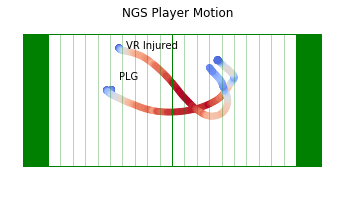

In [42]:
plot_ngs_data(ngs_combined,2016, 144, 2342)

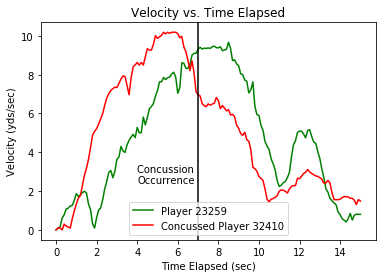

In [43]:
plot_vel_vs_time(output['2016 144 2342'][0],output['2016 144 2342'][1])
plt.axvline(7,c='k');
plt.text(4,2.4,'Concussion \nOccurrence');


**Scenario 2**

* Concussion occurred when non-injured player was running at near  full speed and the injured player was running at full speed.


* Worth noting that the injured player lead with his helmet, which caused the concussion.

**Notes**

* In this scenario, there was a high speed collision between both of the players.  High speed collisions generate more energy and can increase the probability of concussions.


* The punt lasted around 12 seconds and the returner was able to return the punt for a decent yardage gain, which allowed the players to build up momentum.


* The injured player was able to gain speed to the point where his head first tackle caused a concussion, otherwise a concussion could have been prevented.


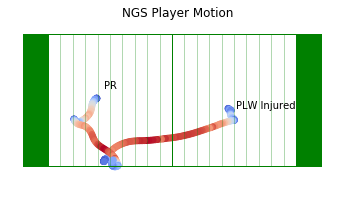

In [44]:
plot_ngs_data(ngs_combined,2016,5,3129)

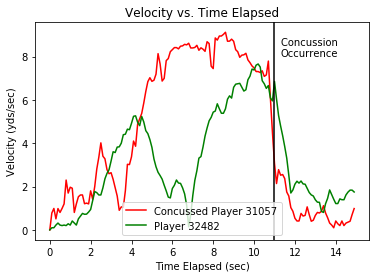

In [45]:
plot_vel_vs_time(output['2016 5 3129'][0],output['2016 5 3129'][1])
plt.axvline(11,c='k');
plt.text(11.3,8,'Concussion \nOccurrence');

**Scenario 3**

* Concussion occurred when the injured player was running at near full speed and was blindsided by an oncoming blocker who led with his helmet.

**Notes**

* As opposed to the other scenarios, this punt was punted across the 50 yard line, was short and was downed inside the 20 yard line.


* However, even though this punt play was only around  6 seconds, the players were able to accelerate quickly and were at near full speed when the concussion occurred 4 seconds into the play. 


* The non-injured player lead in helmet first into the oncoming tackler, which caused the concussion. 


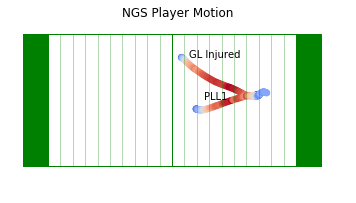

In [46]:
plot_ngs_data(ngs_combined,2016,21,2587)

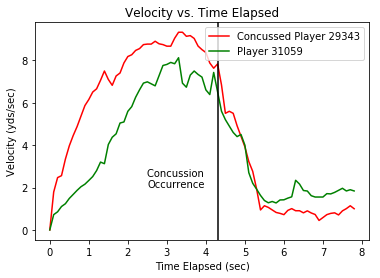

In [47]:
plot_vel_vs_time(output['2016 21 2587'][0],output['2016 21 2587'][1])
plt.axvline(4.3,c='k');
plt.text(2.5,2,'Concussion \nOccurrence');

# Proposed Rule Changes

**A common theme of concussions that occur are twofold:**

1. Improper Tackling or Blocking Leading with Helmet
    * Some of which are intentional and are unintentional (due to biomechanics)
    * Can cause sudden change in movement of the head, which lead to concussions



2. High Velocity Impact
    * Leads to larger energy transfer, which can increase probability of concussion

## Dangerous Tackling/Blocking Form

* The data shows concussions induced from helmet to helmet contact, which are more intentional, are still prevalent on punt plays and make up for 45.9% of all concussions on punts in 2016-2017

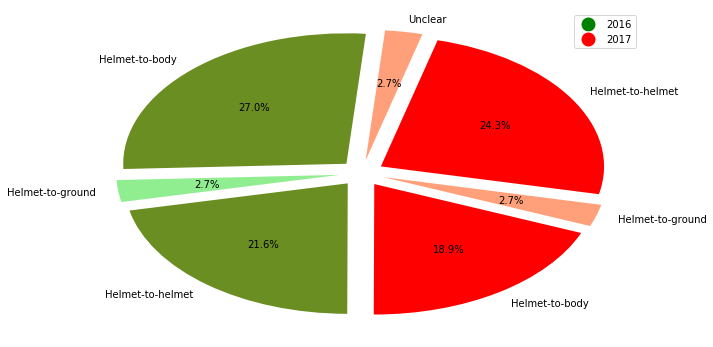

In [48]:
legend_elements = [Line2D([0], [0], marker='o', color='w', label='2016',
                          markerfacecolor='g', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='2017',
                          markerfacecolor='r', markersize=15)]

# Create the figure
fig, ax = plt.subplots()

fig.set_size_inches(10,6)
ax.legend(handles=legend_elements, loc='upper right')
plt.pie(involved_players[involved_players.Injured==1].groupby(['Season_Year','Primary_Impact_Type']).count()['Injured'],
        labels=['Helmet-to-body','Helmet-to-ground','Helmet-to-helmet','Helmet-to-body','Helmet-to-ground','Helmet-to-helmet','Unclear'],
    explode=[.1,.1,.1,.1,.1,.1,.1],colors=['olivedrab','lightgreen','olivedrab','r','lightsalmon','r','lightsalmon'],startangle=85,
       autopct='%1.1f%%');

In [49]:
involved_players[involved_players.Injured==1].groupby(['Season_Year','Primary_Impact_Type']).count()['Injured']

Season_Year  Primary_Impact_Type
2016         Helmet-to-body         10
             Helmet-to-ground        1
             Helmet-to-helmet        8
2017         Helmet-to-body          7
             Helmet-to-ground        1
             Helmet-to-helmet        9
             Unclear                 1
Name: Injured, dtype: int64

### Chi Square Test to test and see effectiveness of new rule change from 2016-2017

In [50]:
involved_players.groupby('Season_Year')['GameKey'].count()

Season_Year
2016    37
2017    33
Name: GameKey, dtype: int64

In [51]:
# chisquare([2016 freq,2017 freq],[expected_freq for 2016, expected_freq for 2017])
chisquare([37,33],[37,37])

Power_divergenceResult(statistic=0.43243243243243246, pvalue=0.5107977981738965)

* The resulting p-value is 0.51.  This means there is a 51% chance that this rule change caused a significant reduction in concussions, which means there is no significant statistical evidence to support that claim.


* From the Chi-Square analysis, stricter rule changes need to be made to prevent this dangerous tackling and blocking form.
    * This assumes that the rules added to the 2018 NFL Rule book have not reduced the number of concussions on punt plays.
    
      
    
* A radical new rule for the NFL can incorporate a similar targeting rule employed in college football to help eliminate this dangerous football move to massively reduce number of concussions.
    1. First review can be done to establish intent of the helmet leading tackle or block of which will either confirm or reverse the call.
    2. If a player is charged with two targeting calls, then the player is removed from the game.


# Similar NBA Ejection Structure to Proposed Solution

* A similar ejection rule structure is emphasized in the NBA, where if one player gets two technical fouls, then they are ejected from the game.

In [143]:
nba_techs=pd.read_csv('../input/nba_data/nba_stats.txt',sep='\t')

In [144]:
tech_per_eject=round((nba_techs['TECH']/nba_techs['EJECT']).mean(),2)
print('Average Technical Fouls per Ejection: '+str(tech_per_eject))

Average Technical Fouls per Ejection: 4.49


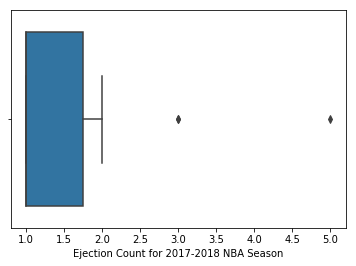

In [63]:
sns.boxplot(nba_techs['EJECT']);
plt.xlabel('Ejection Count for 2017-2018 NBA Season');

* The data shows that once a player commits a technical foul in a game, they are less likely to commit a second technical foul the rest of the game.
    * From a sample taken from foxsports.com:
        * On average a player averages 4.49 technical fouls per ejection.
        * This means that players typically do not commit another technical foul after committing one technical foul.

## Dealing with High Velocity Impact

* Since there is no data showing the point in time when a player was hit, the data was filtered out to only include players who got a concussion as a result of a tackle.
    * The velocity that is displayed below is the velocity of players when 
        * A punt was received or
        * A punt was downed or
        * A punt was kicked out of bounds


In [52]:
ngs_combined1=ngs_combined[(ngs_combined.Event=='punt_received')|(ngs_combined.Event=='out_of_bounds')|(ngs_combined.Event=='punt_downed')]
ngs_combined1['Velocity']=ngs_combined1['dis']/0.1
ngs_combined1.groupby('Primary_Impact_Type')['Velocity'].mean()

ngs1_merge_non_injury=pd.merge(ngs1,involved_players,left_on=['Season_Year','GameKey','PlayID','GSISID'],right_on=['Season_Year','GameKey','PlayID','GSISID'],how='outer')
ngs1_merge_non_injury_filt=ngs1_merge_non_injury[ngs1_merge_non_injury.Injured.isnull()]
ngs1_merge_non_injury_filt=ngs1_merge_non_injury_filt[(ngs1_merge_non_injury_filt.Event=='punt_received')|(ngs1_merge_non_injury_filt.Event=='out_of_bounds')|(ngs1_merge_non_injury_filt.Event=='punt_downed')]
ngs1_merge_non_injury_filt['Velocity']=ngs1_merge_non_injury_filt['dis']/0.1
vel_li_non_injury=ngs1_merge_non_injury_filt['Velocity'].values

ngs2_merge_non_injury=pd.merge(ngs2,involved_players,left_on=['Season_Year','GameKey','PlayID','GSISID'],right_on=['Season_Year','GameKey','PlayID','GSISID'],how='outer')
ngs2_merge_non_injury_filt=ngs2_merge_non_injury[ngs2_merge_non_injury.Injured.isnull()]
ngs2_merge_non_injury_filt=ngs2_merge_non_injury_filt[(ngs2_merge_non_injury_filt.Event=='punt_received')|(ngs2_merge_non_injury_filt.Event=='out_of_bounds')|(ngs2_merge_non_injury_filt.Event=='punt_downed')]
ngs2_merge_non_injury_filt['Velocity']=ngs2_merge_non_injury_filt['dis']/0.1
np.append(vel_li_non_injury,ngs2_merge_non_injury_filt['Velocity'].values)

ngs3_merge_non_injury=pd.merge(ngs3,involved_players,left_on=['Season_Year','GameKey','PlayID','GSISID'],right_on=['Season_Year','GameKey','PlayID','GSISID'],how='outer')
ngs3_merge_non_injury_filt=ngs3_merge_non_injury[ngs3_merge_non_injury.Injured.isnull()]
ngs3_merge_non_injury_filt=ngs3_merge_non_injury_filt[(ngs3_merge_non_injury_filt.Event=='punt_received')|(ngs3_merge_non_injury_filt.Event=='out_of_bounds')|(ngs3_merge_non_injury_filt.Event=='punt_downed')]
ngs3_merge_non_injury_filt['Velocity']=ngs3_merge_non_injury_filt['dis']/0.1
np.append(vel_li_non_injury,ngs3_merge_non_injury_filt['Velocity'].values)

ngs4_merge_non_injury=pd.merge(ngs4,involved_players,left_on=['Season_Year','GameKey','PlayID','GSISID'],right_on=['Season_Year','GameKey','PlayID','GSISID'],how='outer')
ngs4_merge_non_injury_filt=ngs4_merge_non_injury[ngs4_merge_non_injury.Injured.isnull()]
ngs4_merge_non_injury_filt=ngs4_merge_non_injury_filt[(ngs4_merge_non_injury_filt.Event=='punt_received')|(ngs4_merge_non_injury_filt.Event=='out_of_bounds')|(ngs4_merge_non_injury_filt.Event=='punt_downed')]
ngs4_merge_non_injury_filt['Velocity']=ngs4_merge_non_injury_filt['dis']/0.1
np.append(vel_li_non_injury,ngs4_merge_non_injury_filt['Velocity'].values)

ngs5_merge_non_injury=pd.merge(ngs5,involved_players,left_on=['Season_Year','GameKey','PlayID','GSISID'],right_on=['Season_Year','GameKey','PlayID','GSISID'],how='outer')
ngs5_merge_non_injury_filt=ngs5_merge_non_injury[ngs5_merge_non_injury.Injured.isnull()]
ngs5_merge_non_injury_filt=ngs5_merge_non_injury_filt[(ngs5_merge_non_injury_filt.Event=='punt_received')|(ngs5_merge_non_injury_filt.Event=='out_of_bounds')|(ngs5_merge_non_injury_filt.Event=='punt_downed')]
ngs5_merge_non_injury_filt['Velocity']=ngs5_merge_non_injury_filt['dis']/0.1
np.append(vel_li_non_injury,ngs5_merge_non_injury_filt['Velocity'].values)

vel_li_non_injury


array([0.90000004, 5.40000021, 1.80000007, ..., 4.09999996, 8.29999983,
       5.69999993])

* Since there is no data showing the point in time when a player was hit, the data was filtered out to only include players who got a concussion as a result of a tackle.


* The velocity that is displayed below is the velocity of players when 
    * A punt was received or
    * A punt was downed or
    * A punt was kicked out of bounds


In [67]:
ngs_combined1.groupby('Primary_Impact_Type')['Velocity'].mean()

Primary_Impact_Type
Helmet-to-body      6.668750
Helmet-to-ground    8.400000
Helmet-to-helmet    4.594444
Name: Velocity, dtype: float64

* The average player velocity on a developed punt play is high on plays with concussions as seen above.


* The boxplot below shows the average player velocity on a developed punt play on plays with no concussions:

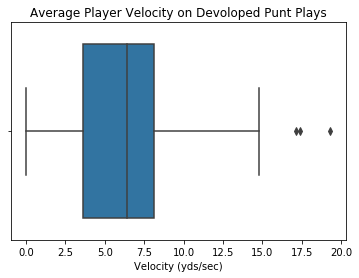

In [53]:
sns.boxplot(vel_li_non_injury);
plt.title('Average Player Velocity on Devoloped Punt Plays');
plt.xlabel('Velocity (yds/sec)');

In [74]:
print('The average player velocity on a developed punt play on plays with no concussions is '+str(round(vel_li_non_injury.mean(),2))+ ' yds/sec')
print()
print('The average player velocity standard deviation on a developed punt play on plays with no concussions are '+str(round(vel_li_non_injury.std(),2))+ ' yds/sec')

The average player velocity on a developed punt play on plays with no concussions is 5.83 yds/sec

The average player velocity standard deviation on a developed punt play on plays with no concussions are 2.76 yds/sec


* For the players of focus in a punt formation near the line of scrimmage near the long snapper, their average velocities are in general faster during punt plays that have concussions.

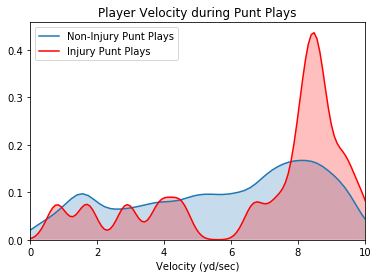

In [56]:
sns.kdeplot(vel_li_non_injury,bw=0.31,shade=True,label='Non-Injury Punt Plays')
sns.kdeplot(ngs_combined1[ngs_combined1.Role.isin(los_pos)].Velocity,bw=0.3,color='r',label='Injury Punt Plays',shade=True)
plt.xlim(0,10);
plt.title('Player Velocity during Punt Plays');
plt.xlabel('Velocity (yd/sec)');

* For the velocities that are slower than 5 yds/sec, the main primary impact type were all helmet to helmet hits.

In [76]:
ngs_combined1[(ngs_combined1.Role.isin(los_pos))&(ngs_combined1.Velocity<5)].groupby('Primary_Impact_Type').count()['PlayID']

Primary_Impact_Type
Helmet-to-helmet    5
Name: PlayID, dtype: int64

* The data shows that for hits that occur at faster speeds, concussions are more likely.  However, for concussions that occur at slower speeds, helmet to helmet contact is the only causing factor.


* With this said, even though the velocity statistics are not statistically different between punt plays with concussions versus those without, the punt play formation still needs to be changed to fundamentally help reduce the average player speed as much as possible to reduce concussion provoking plays.


* To maintain the integrity of the game so that the resulting punt play is similar to the original, only the formation alignment will be changed to reduce the average player’s velocity on punt plays to help reduce concussions.


# Proposed Rule Changes: 
  **Changing the Punt Formation**  

* An area of interest is to identify the players who are most frequently involved in concussion inducing punt plays.


* Concussion Player Involvement is identified as being a player who either experiences a concussion or whose contact triggers a concussion of another player.


* Is important to understand which positions of a punt formation are more likely to have concussion player involvement and identify why those positions are more likely to induce concussions.


# Proposed Rule Changes:
   * Changing the Punt Formation:
        * Concussion Player Involvement for Punt Coverage Formations

### Making DataFrame that Shows Involved Players in Concussion Play

In [6]:
df=pd.read_csv('../input/video_review.csv')
role=pd.read_csv('../input/play_player_role_data.csv')

injured_player=pd.merge(df,role,left_on=['Season_Year','GameKey','PlayID','GSISID'],right_on=['Season_Year','GameKey','PlayID','GSISID'])

In [7]:
df.Primary_Partner_GSISID=df.Primary_Partner_GSISID.replace([np.nan,'Unclear'],0)
df.Primary_Partner_GSISID=df.Primary_Partner_GSISID.map(int)

In [8]:
involved_player=pd.merge(role,df,left_on=['Season_Year','GameKey','PlayID','GSISID'],right_on=['Season_Year','GameKey','PlayID','Primary_Partner_GSISID'])
involved_player1=involved_player.rename(columns={'GSISID_x':'Involved_Player_GSISID','GSISID_y':'Injured_Player_GSISID'})

injured_player2=injured_player[['Season_Year', 'GameKey', 'PlayID', 'GSISID','Role', 'Player_Activity_Derived',
        'Primary_Impact_Type']]
involved_player2=involved_player1[['Season_Year', 'GameKey', 'PlayID', 'Involved_Player_GSISID', 'Role','Player_Activity_Derived',
                                   'Primary_Impact_Type']]

involved_player2=involved_player2.rename(columns={'Involved_Player_GSISID':'GSISID'})

involved_player2['Index']=np.arange(37,len(involved_player2)+37)
involved_player2.set_index('Index',inplace=True)

involved_player2['Injured']=0
injured_player2['Injured']=1

concussion_inv=pd.concat([injured_player2,involved_player2])

* Below are the First 5 Rows of the DataFrame that shows the involved players of a concussion play along with their punt role.  The 'Injured' column allows the capability to easily filter the uninjured players from the injured ones.

In [9]:
concussion_inv.head()

,Season_Year,GameKey,PlayID,GSISID,Role,Player_Activity_Derived,Primary_Impact_Type,Injured
0,2016,5,3129,31057,PLW,Tackling,Helmet-to-body,1
1,2016,21,2587,29343,GL,Blocked,Helmet-to-helmet,1
2,2016,29,538,31023,GR,Tackling,Helmet-to-body,1
3,2016,45,1212,33121,PRT,Tackling,Helmet-to-body,1
4,2016,54,1045,32444,PRT,Blocked,Helmet-to-body,1


### Making graphic that shows the positions that are most frequently involved in concussions on punt plays.

In [10]:
role_injured=injured_player2.groupby('Role').count()[['GameKey']]
role_part=involved_player2.groupby('Role').count()[['GameKey']]

positions_li_cov=['GR','PRT','PRG','PLS','PLG','PLT','GL','PRW','PLW','PC','PPR','P']
positions_li_ret=['VRo','VRi','PDR1','PDR2','PDR3','PDL3','PDL2','PDL1','VL',
             'PLR','PLM','PLL','PFB','PR']

los_pos=['PRT','PRG','PLS','PLG','PLT','PRW','PLW','PDR1','PDR2','PDR3','PDL3','PDL2','PDL1','PLR','PLM','PLL']

df_pos=pd.DataFrame(role_part,index=(positions_li_ret+positions_li_cov),columns=['Count'])
df_pos=df_pos.replace(np.nan,0)

df_role_injured=pd.DataFrame(pd.merge(df_pos,role_injured,left_index=True,right_index=True,how='outer').sum(axis=1),columns=['Count'])

role_part=role_part.rename(index={'PLL1':'PLL','VLo':'VL'})

df_role_part=pd.DataFrame(pd.merge(df_pos,role_part,left_index=True,right_index=True,how='outer').sum(axis=1),columns=['Count'])

df_role_injured.at['VRi']=1

df_role_injured.drop('VR',inplace=True)

df_pos_ovr=df_role_injured+df_role_part

df_pos_ovr['Return']=[0,0,0,0,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,1,0,0,0,1,1,1]

df_pos_ovr=df_pos_ovr.reindex((positions_li_cov+positions_li_ret))

* Count Information of All the Punt Coverage and Return Formation Positions as specified by the Data Manual

In [146]:
concussion_inv.to_csv(path+'concussion_inv.csv')

In [11]:
df_pos_ovr

,Count,Return
GR,5.0,0
PRT,4.0,0
PRG,6.0,0
PLS,3.0,0
PLG,5.0,0
PLT,4.0,0
GL,4.0,0
PRW,3.0,0
PLW,5.0,0
PC,0.0,0


* Graphic Showing the Positions that are most involved in the **Punt Coverage Formation** with the counts specified by <span style='color:blue'>blue</span>  to<span style='color:red'> red </span>color mapping:

<span style='color:blue'>
Low Involvement  </span> to
<span style='color:red'>    
Highly Involved </span>

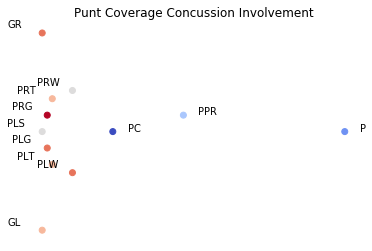

In [12]:
#Punt Coverage
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axis('off')
ovr=df_pos_ovr[df_pos_ovr.Return==0]

x=[0,0.1,0.05,0,0.05,0.1,0,0.3,0.3,0.7,1.4,3]
y=[10,6,5,4,3,2,-2,6.5,1.5,4,5,4]
plt.scatter(x,y,c=df_pos_ovr[df_pos_ovr.Return==0]['Count'],cmap=cm.coolwarm)

plt.tick_params(       
    bottom=False,      
    top=False,        
    labelbottom=False,
    left=False,
    labelleft=False) 

counter=0
for i,j in zip(x,y):
    if i<0.7:
        ax.annotate(ovr.index[counter], xy=(i,j), xytext=(-35,5), textcoords='offset points')
    if i>=0.7:
        ax.annotate(ovr.index[counter], xy=(i,j), xytext=(15,0), textcoords='offset points')
    counter+=1
plt.title('Punt Coverage Concussion Involvement');

* As indicated from the Data, it can be seen majority of the players who are involved in concussion plays are at or near the line of scrimmage, which is 92.9%.

In [78]:
cov_form_count=df_pos_ovr[((df_pos_ovr.index.isin(los_pos+['GR','GL'])))&(df_pos_ovr.Return==0)].sum()['Count']
los_percent_cov=cov_form_count/df_pos_ovr[df_pos_ovr.Return==0].sum()['Count']
round(los_percent_cov,3)

0.929

* However, after calculating the gunners’ concussion involvement proportion from the players at or near the line of scrimmage, the percentage accounted for only 21.4% of those players involved in concussion inducing punt plays.

In [79]:
cov_form_count_only_los=df_pos_ovr[((df_pos_ovr.index.isin(los_pos)))&(df_pos_ovr.Return==0)].sum()['Count']
los_percent_cov_byball=los_percent_cov-cov_form_count_only_los/df_pos_ovr[df_pos_ovr.Return==0].sum()['Count']
round(los_percent_cov_byball,3)

0.214

* This indicates, that approximately 71.4% of players who are involved concussion inducing plays are at or near the line of scrimmage near the football snap location.

In [80]:
round(los_percent_cov-los_percent_cov_byball,3)

0.714

* Graphic Showing the Positions that are most involved in the **Punt Return Formation** with the counts specified by <span style='color:blue'>blue</span>  to<span style='color:red'> red </span>color mapping:

<span style='color:blue'>
Low Involvement  </span>to
<span style='color:red'>    
High Involvement </span>

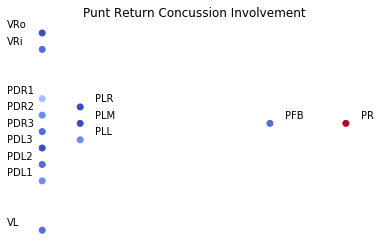

In [16]:
#Punt Return
fig = plt.figure()
ax = fig.add_subplot(111)
ovr=df_pos_ovr[df_pos_ovr.Return==1]

ax.axis('off')

x=[0,0,0,0,0,0,0,0,0,1,1,1,6,8]
y=[10,9,6,5,4,3,2,1,-2,5.5,4.5,3.5,4.5,4.5]
plt.scatter(x,y,c=ovr['Count'],cmap=cm.coolwarm)


plt.tick_params(       
    bottom=False,      
    top=False,        
    labelbottom=False,
    left=False,
    labelleft=False) 

counter=0
for i,j in zip(x,y):
    if i==0:

        ax.annotate(ovr.index[counter], xy=(i,j), xytext=(-35,5), textcoords='offset points')
    else:

        ax.annotate(ovr.index[counter], xy=(i,j), xytext=(15,5), textcoords='offset points')
    
    
    counter+=1
plt.title('Punt Return Concussion Involvement');

* As indicated from the data, it can be seen that the most frequent position of concussion involvement is the PR position, the position that fields the punts.  

* The proportion for that position alone accounts for approximately 46.4% of all concussion involved players that are in the return formation.

* It makes sense that the most frequent position of involvement in concussion inducing plays is the PR position because that is the main focus of protection/attack once the PR fields the ball.

In [82]:
return_form_count=df_pos_ovr[(df_pos_ovr.index.isin(['PR']))&(df_pos_ovr.Return==1)].sum()['Count']
round(return_form_count/df_pos_ovr[df_pos_ovr.Return==1].sum()['Count'],3)

0.464

* The proportion of players involved in concussion inducing plays that are at or near the line of scrimmage and take on blockers only account for nearly 43% of the involved players that are in the return formation.

In [83]:
return_form_count=df_pos_ovr[(df_pos_ovr.index.isin(los_pos))&(df_pos_ovr.Return==1)].sum()['Count']
round(return_form_count/df_pos_ovr[df_pos_ovr.Return==1].sum()['Count'],3)

0.429

## Overall Concussion Involvement

* Including the PR position, players at or near the line of scrimmage in the trenches account for 60% of all players involved in concussion inducing events.

In [19]:
df_pos_ovr[df_pos_ovr.index.isin(los_pos)].sum()['Count']/df_pos_ovr['Count'].sum()

0.6

* Without accounting for the PR position, players at or near the line of scrimmage in the trenches account for 73.7% of all players involved in concussion inducing events.

* Due to such a high proportion of involvement, any changes that need to be made, need to be focused on these players at or near the line of scrimmage by the ball snap location.

In [84]:
print(df_pos_ovr.iloc[-1].name)
round(df_pos_ovr[df_pos_ovr.index.isin(los_pos)].sum()['Count']/df_pos_ovr['Count'].iloc[:-1].sum(),3)

PR


0.737

# Proposed Rule Changes
   * Changing the Punt Formation:
        * Cause of Concussion Involvement

* Comparing the velocity of the players that are at or near the line of scrimmage by the snap location (or punt non-gunners) to the gunner players, it is seen that their velocities are in general faster at the time when punt plays are fair caught or are fielded.

### Making the appropriate datasets for this analysis.

In [116]:
ngs1_fair_catch=ngs1[ngs1.Event=='fair_catch']
ngs2_fair_catch=ngs2[ngs2.Event=='fair_catch']
ngs3_fair_catch=ngs3[ngs3.Event=='fair_catch']
ngs4_fair_catch=ngs4[ngs4.Event=='fair_catch']
ngs5_fair_catch=ngs5[ngs5.Event=='fair_catch']

In [117]:
injured_player['Injured']=1
injured_player=injured_player[['Season_Year','GameKey','PlayID','Injured']]

In [118]:
fin_fair_catch=pd.concat([ngs1_fair_catch,ngs2_fair_catch,ngs3_fair_catch,ngs4_fair_catch,ngs5_fair_catch])

In [119]:
merged_fair_catch=pd.merge(role,fin_fair_catch,left_on=['Season_Year','GameKey','PlayID','GSISID'],right_on=['Season_Year','GameKey','PlayID','GSISID'])
merged_fair_catch=pd.merge(merged_fair_catch,injured_player,left_on=['Season_Year','GameKey','PlayID'],right_on=['Season_Year','GameKey','PlayID'],how='left')
merged_fair_catch['Injured']=merged_fair_catch['Injured'].fillna(0)
merged_fair_catch['Velocity']=merged_fair_catch['dis']/0.1

In [120]:
gunner=['VRo','VRi','VL','GR','GL']
los_pos=['PRT','PRG','PLS','PLG','PLT','PRW','PLW','PDR1','PDR2','PDR3','PDL3','PDL2','PDL1','PLR','PLM','PLL']

In [121]:
merged_fair_catch_non_gunner=merged_fair_catch[merged_fair_catch.Role.isin(los_pos)][['Velocity']]
merged_fair_catch_gunner=merged_fair_catch[merged_fair_catch.Role.isin(gunner)][['Velocity']]

* Comparing the velocity of the players that are at or near the line of scrimmage by the snap location (or punt non-gunners) to the gunner players, it is seen that their velocities are in general faster at the time when punt plays are fair caught.

* A reason for this is because the gunners get to the punt returner rather quickly so that they in most cases have to slow down, whereas the other players are playing ‘catch up’ to the gunners and therefore they are on average faster during those times.

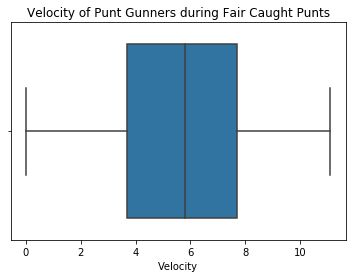

In [133]:
sns.boxplot(merged_fair_catch_gunner.Velocity);
plt.title('Velocity of Punt Gunners during Fair Caught Punts');
plt.savefig('C:/Users/blake.gonthier/Desktop/NFL Punt Analytics/Viz/punt_gunner_velocity.png')

In [135]:
print('Punt Gunners average velocity at time of when a punt if fair caught or is fielded: '+str(round(merged_fair_catch_gunner.Velocity.mean(),2))+' yds/sec.')

Punt Gunners average velocity at time of when a punt if fair caught or is fielded: 5.66 yds/sec.


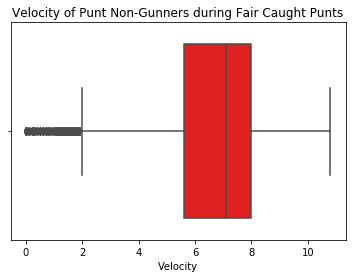

In [132]:
sns.boxplot(merged_fair_catch_non_gunner.Velocity,color='r');
plt.title('Velocity of Punt Non-Gunners during Fair Caught Punts');

In [134]:
print('Punt Gunners average velocity at time of when a punt if fair caught or is fielded: '+str(round(merged_fair_catch_non_gunner.Velocity.mean(),2))+' yds/sec.')

Punt Gunners average velocity at time of when a punt if fair caught or is fielded: 6.67 yds/sec.


### Checking if there is a statisically proven difference between the velocities of players who are gunners versus those who are not.

In [136]:
ttest_ind(merged_fair_catch_non_gunner,merged_fair_catch_gunner,equal_var=False)

Ttest_indResult(statistic=array([19.61429044]), pvalue=array([2.47525055e-81]))

* Statistically proving that both of these samples of velocities between the punt gunners and the punt non-gunners, a 2 sample independent t-test was used


* The test gave a p-value of 2.47e-81.  That means that both of these samples statistically have a different velocity population.


* Therefore, the gunner position is statistically slower at the time when a punt is fair caught or fielded than the non-gunner positions that are at or near the line of scrimmage by the ball snap location.


# Proposed Rule Changes
## Changing the Punt Formation: 
### Proposed Solution

* It would comprise of reducing the allowed number of players at or near the line of scrimmage by the ball snap location for both the return team and the coverage team.


* Currently there are at least 10 players at or near the line of scrimmage by the ball snap location.


* By allowing only 8 players in this area, this will reduce the number of players who are running full speed down the field.


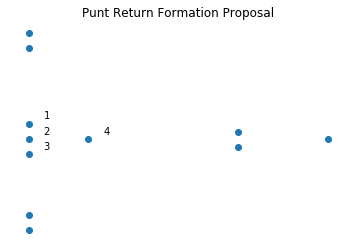

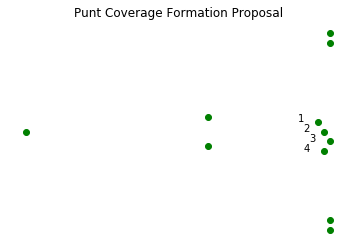

In [137]:
#Punt Return
number=np.arange(1,12)
fig = plt.figure()
ax = fig.add_subplot(111)
ovr=df_pos_ovr[df_pos_ovr.Return==1]

ax.axis('off')



x=[0,0,0,0,0,0,0,0.2,0.7,0.7,1]
y=[10,9,4,3,2,-2,-3,3,3.5,2.5,3]


plt.scatter(x,y)


plt.tick_params(       
    bottom=False,      
    top=False,        
    labelbottom=False,
    left=False,
    labelleft=False)

label_x=[0,0,0,0.2]
label_y=[4,3,2,3]

counter=0
for i,j in zip(label_x,label_y):
    ax.annotate(number[counter], xy=(i,j), xytext=(15,5), textcoords='offset points')

    
    counter+=1
plt.title('Punt Return Formation Proposal');

#Punt Coverage
number=np.arange(1,12)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axis('off')
ovr=df_pos_ovr[df_pos_ovr.Return==0]

# x=[0,-0.1,-0.05,0,-0.05,-0.1,0,-0.3,-0.3,-0.7,-1.4,-3]
# y=[10,6,5,4,3,2,-2,6.5,1.5,4,5,4]

x=-0.1,-0.1,-5,-2,-2
y=1,-1,0,1.5,-1.5

x=[0,0,-0.2,-0.1,0,-0.1,0,0,-2,-2,-5]
y=[10,9,1,0,-1,-2,-9,-10,1.5,-1.5,0]
plt.scatter(x,y,c='g')

plt.tick_params(       
    bottom=False,      
    top=False,        
    labelbottom=False,
    left=False,
    labelleft=False) 

counter=0
label_x=[-0.2,-0.1,0,-0.1]
label_y=[1,0,-1,-2]
for i,j in zip(label_x,label_y):
    ax.annotate(number[counter], xy=(i,j), xytext=(-20,0), textcoords='offset points')

    counter+=1
plt.title('Punt Coverage Formation Proposal');

### Proposed Solution Consequences:


* Would increase the number of fair catches 


* Should limit the number of punts fielded



* Would limit the number of concussions experienced by the punt returner


* More teams will line up players who are not typical blockers or rushers in the gunner position, which would reduce the collision force.


* Still gives the punt returner a chance to field the punt so the punt play is still preserved
Less Dense Field in specific parts of the field to avoid accidental collisions between players


# Conclusion

* The NFL needs to focus on enforcing stricter penalties for leading with the helmet on contact plays:
    * First review can be done to establish intent of the helmet leading tackle or block of which will either confirm or reverse the call.
    * If a player is charged with two targeting calls, then the player is removed from the game.


* The NFL needs to enforce a particular type of punt return or punt coverage formation to reduce the velocities of players on punts:
    * Limit the number of players allowed near the ball snap location to 4 players per team 
